# NLP 2025-26 -- LLM Project: Email Routing Agents

**Objective:** Develop three LLM-based agents to automatically route customer support emails to the appropriate department.

**Departments:** Technical Support, Customer Service, Billing and Payments, Sales and Pre-Sales, General Inquiry

**Agents:**
1. Routing with prompting using GPT-2 (frozen model)
2. Routing with fine-tuning (LoRA) on GPT-2
3. Routing with discriminative classifier using DistilBERT

## 0. Setup and Imports

Import all required libraries and detect the best available compute device (CUDA for NVIDIA GPUs, MPS for Apple Silicon, or CPU as fallback).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import tracemalloc
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import (
    GPT2Tokenizer, GPT2LMHeadModel,
    DistilBertTokenizer, DistilBertForSequenceClassification,
)
from tqdm import tqdm

from datapreparation import load_and_prepare_data

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: mps


## 1. Data Loading and Exploration

Load the customer support ticket dataset using `load_and_prepare_data()` from `datapreparation.py`. This filters for English emails, keeps only the 5 target departments, shuffles, and splits into train (80%), validation (10%), and test (10%) sets.

In [2]:
train_ds, val_ds, test_ds, label_list, label2id, id2label = load_and_prepare_data()

print(f"Train size: {len(train_ds)}")
print(f"Validation size: {len(val_ds)}")
print(f"Test size: {len(test_ds)}")
print(f"Labels: {label_list}")

Label distribution (train):
Counter({'Technical Support': 6476, 'Customer Service': 3471, 'Billing and Payments': 2307, 'Sales and Pre-Sales': 655, 'General Inquiry': 340})
Train size: 13249
Validation size: 1656
Test size: 1657
Labels: ['Billing and Payments', 'Customer Service', 'General Inquiry', 'Sales and Pre-Sales', 'Technical Support']


The dataset contains 13,249 training, 1,656 validation, and 1,657 test samples. The class distribution is heavily imbalanced: Technical Support dominates (~49%), while General Inquiry is the smallest class (~2.5%).

Visualize the label distribution across train, validation, and test splits to check for class imbalance.

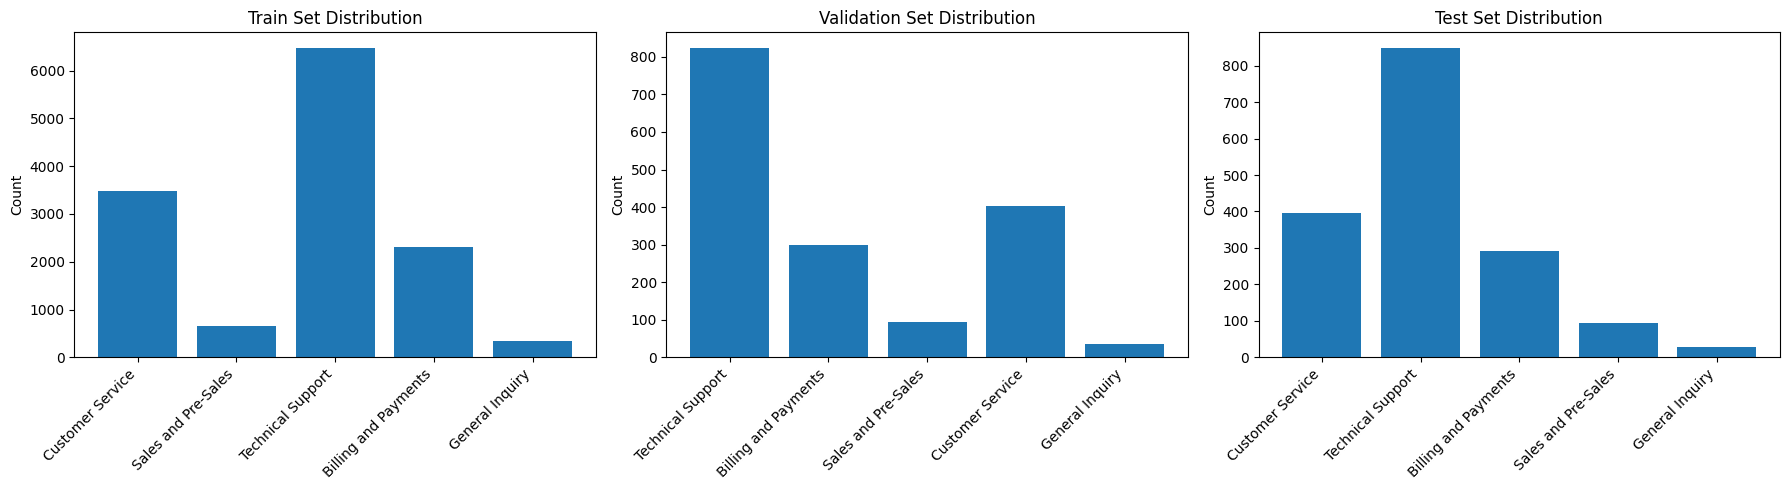

In [3]:
# Visualize label distribution
from collections import Counter

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, (name, split) in zip(axes, [("Train", train_ds), ("Validation", val_ds), ("Test", test_ds)]):
    counts = Counter(split["queue"])
    ax.bar(range(len(counts)), counts.values())
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.keys(), rotation=45, ha="right")
    ax.set_title(f"{name} Set Distribution")
    ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

The bar charts confirm the class imbalance is consistent across all three splits. Technical Support has roughly 6x more samples than Sales and Pre-Sales, and 19x more than General Inquiry. This imbalance will affect model performance, especially for minority classes.

Print a few sample emails to understand the structure of the data (subject, body, and assigned department).

In [4]:
# Inspect a few examples
for i in range(3):
    print(f"--- Example {i+1} ---")
    print(f"Subject: {train_ds[i]['subject']}")
    print(f"Body: {train_ds[i]['body'][:200]}...")
    print(f"Department: {train_ds[i]['queue']}")
    print()

--- Example 1 ---
Subject: Guidance on Investment Data Analytics
Body: Is it possible to receive guidance on optimizing investments through the use of data analytics and available tools and services? I am interested in learning how to make data-driven decisions....
Department: Customer Service

--- Example 2 ---
Subject: None
Body: Dear customer support, the data analytics tool is failing to process investment data efficiently. The problem might be due to software compatibility issues. After updating the associated software devi...
Department: Sales and Pre-Sales

--- Example 3 ---
Subject: Concern Regarding CRM System Malfunction
Body: Dear Support Team, our marketing agency is facing issues with the Salesforce CRM system, which is disrupting our client data management process. It seems that recent software updates or integration er...
Department: Customer Service



Each email has a subject (which can be `None`), a body with the full message text, and a queue (department label). The emails vary in length and formality, and some subjects are missing — the model needs to handle both fields.

---
## 2. Agent 1: Routing with Prompting (Frozen GPT-2)

This agent uses a pretrained GPT-2 model **without any training or weight updates** (frozen). Classification is done via **log-likelihood scoring**: for each email, we build an instruction-style prompt and compute the probability of each department name as a completion. The department with the highest normalized log-probability is selected as the prediction.

Define the helper functions for Agent 1:
- `build_prompt`: constructs an instruction-style prompt from the email subject and body.
- `score_labels_gpt2`: scores each department label by computing its log-likelihood as a completion of the prompt. Uses KV-cache to avoid redundant computation — the prompt is forwarded once and cached, then only the label tokens are forwarded for each candidate.
- `evaluate_gpt2_prompting`: runs the scoring over an entire dataset split, tracking time and memory.

In [5]:
def build_prompt(subject, body, max_body_chars=500):
    """Build an instruction-style prompt for email routing."""
    body_truncated = body[:max_body_chars].strip()
    prompt = (
        "Classify the following customer support email into exactly one department.\n"
        "Departments: Technical Support, Customer Service, Billing and Payments, Sales and Pre-Sales, General Inquiry\n\n"
        f"Subject: {subject}\n"
        f"Body: {body_truncated}\n\n"
        "Department:"
    )
    return prompt


def score_labels_gpt2(model, tokenizer, prompt, label_list, device):
    """Score each label using KV-cache: forward the prompt once, then score each label's tokens."""
    prompt_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        prompt_out = model(prompt_ids, use_cache=True)
        past_kv = prompt_out.past_key_values
        last_logit = prompt_out.logits[:, -1, :]

    scores = {}
    for label in label_list:
        label_ids = tokenizer.encode(" " + label, add_special_tokens=False)
        log_probs = torch.nn.functional.log_softmax(last_logit, dim=-1)
        total_log_prob = log_probs[0, label_ids[0]].item()

        cached = past_kv
        for i in range(1, len(label_ids)):
            prev_token = torch.tensor([[label_ids[i - 1]]], device=device)
            with torch.no_grad():
                out = model(prev_token, past_key_values=cached, use_cache=True)
                cached = out.past_key_values
                lp = torch.nn.functional.log_softmax(out.logits[:, -1, :], dim=-1)
                total_log_prob += lp[0, label_ids[i]].item()

        scores[label] = total_log_prob / len(label_ids)

    return max(scores, key=scores.get)


def evaluate_gpt2_prompting(model, tokenizer, dataset, label_list, device, desc="Evaluating"):
    """Run prompting-based evaluation on a dataset split. Returns predictions, true labels, elapsed time, peak memory."""
    model.eval()
    predictions = []
    true_labels = []

    tracemalloc.start()
    start_time = time.time()

    for example in tqdm(dataset, desc=desc):
        prompt = build_prompt(example["subject"], example["body"])
        pred = score_labels_gpt2(model, tokenizer, prompt, label_list, device)
        predictions.append(pred)
        true_labels.append(example["queue"])

    elapsed = time.time() - start_time
    _, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return predictions, true_labels, elapsed, peak_memory

### 2.1 GPT-2 Prompting

Load the pretrained GPT-2 model (124M parameters, frozen) and run a sanity check on a single test example before evaluating on the full test set.

In [6]:
# Load GPT-2 (frozen)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
gpt2_model.eval()

# Quick sanity check on one example
sample_prompt = build_prompt(test_ds[0]["subject"], test_ds[0]["body"])
sample_pred = score_labels_gpt2(gpt2_model, gpt2_tokenizer, sample_prompt, label_list, device)
print(f"Sample prediction: {sample_pred}")
print(f"True label: {test_ds[0]['queue']}")

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sample prediction: Customer Service
True label: Customer Service


Evaluate the frozen GPT-2 model on the full test set. Print accuracy, per-class precision/recall, inference time, and peak memory usage.

In [7]:
# Evaluate GPT-2 on the full test set
gpt2_preds, gpt2_true, gpt2_time, gpt2_mem = evaluate_gpt2_prompting(
    gpt2_model, gpt2_tokenizer, test_ds, label_list, device, desc="GPT-2 Prompting"
)

gpt2_acc = accuracy_score(gpt2_true, gpt2_preds)
print(f"\nGPT-2 Prompting Accuracy: {gpt2_acc:.4f}")
print(f"Time: {gpt2_time:.1f}s | Peak Memory: {gpt2_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(gpt2_true, gpt2_preds, target_names=label_list, zero_division=0))

GPT-2 Prompting: 100%|██████████| 1657/1657 [04:47<00:00,  5.76it/s]


GPT-2 Prompting Accuracy: 0.2269
Time: 287.5s | Peak Memory: 0.7 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.29      0.27      0.28       291
    Customer Service       0.20      0.21      0.20       395
     General Inquiry       0.00      0.00      0.00        29
 Sales and Pre-Sales       0.06      0.45      0.11        93
   Technical Support       0.59      0.20      0.30       849

            accuracy                           0.23      1657
           macro avg       0.23      0.23      0.18      1657
        weighted avg       0.40      0.23      0.26      1657



**GPT-2 Prompting Results:** 22.7% accuracy — barely above random chance (20% for 5 classes). The model heavily over-predicts "Sales and Pre-Sales" (45% recall but only 6% precision) while completely missing "General Inquiry" (0% recall). This is expected: GPT-2 is a base language model trained for next-token prediction on internet text, not for following instructions. It picks labels based on token probability rather than email content understanding.

### 2.2 DistilGPT-2 Prompting

Load the pretrained DistilGPT-2 model (80M parameters, frozen). Same approach as GPT-2 above, but with a smaller distilled model. Free the GPT-2 model from memory first, then evaluate on the full test set.

In [8]:
# Load DistilGPT-2 (frozen)
distilgpt2_tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")
distilgpt2_model = GPT2LMHeadModel.from_pretrained("distilgpt2").to(device)
distilgpt2_model.eval()

# Free GPT-2 memory if it exists
if 'gpt2_model' in dir():
    del gpt2_model
import gc; gc.collect()
if torch.backends.mps.is_available():
    torch.mps.empty_cache()
elif torch.cuda.is_available():
    torch.cuda.empty_cache()

# Evaluate DistilGPT-2 on the full test set
distilgpt2_preds, distilgpt2_true, distilgpt2_time, distilgpt2_mem = evaluate_gpt2_prompting(
    distilgpt2_model, distilgpt2_tokenizer, test_ds, label_list, device, desc="DistilGPT-2 Prompting"
)

distilgpt2_acc = accuracy_score(distilgpt2_true, distilgpt2_preds)
print(f"\nDistilGPT-2 Prompting Accuracy: {distilgpt2_acc:.4f}")
print(f"Time: {distilgpt2_time:.1f}s | Peak Memory: {distilgpt2_mem / 1e6:.1f} MB")
print("\nClassification Report:")
print(classification_report(distilgpt2_true, distilgpt2_preds, target_names=label_list, zero_division=0))

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
DistilGPT-2 Prompting: 100%|██████████| 1657/1657 [03:01<00:00,  9.14it/s]


DistilGPT-2 Prompting Accuracy: 0.2842
Time: 181.3s | Peak Memory: 0.7 MB

Classification Report:
                      precision    recall  f1-score   support

Billing and Payments       0.33      0.01      0.02       291
    Customer Service       0.22      0.55      0.31       395
     General Inquiry       0.00      0.00      0.00        29
 Sales and Pre-Sales       0.09      0.26      0.14        93
   Technical Support       0.60      0.27      0.37       849

            accuracy                           0.28      1657
           macro avg       0.25      0.22      0.17      1657
        weighted avg       0.42      0.28      0.27      1657



**DistilGPT-2 Prompting Results:** 28.4% accuracy — slightly better than GPT-2 but still near random. DistilGPT-2 is 1.6x faster (181s vs 288s) due to having 6 layers instead of 12, but shows the same fundamental limitation: it over-predicts "Customer Service" (55% recall, 22% precision) and completely ignores "General Inquiry". Both frozen models confirm that base GPT-2 models cannot perform zero-shot classification reliably — fine-tuning is needed.

---
## 3. Agent 2: Routing with Fine-Tuning (LoRA on GPT-2)

Fine-tune GPT-2 using LoRA, then evaluate with the same prompt as Agent 1.

*Implementation coming in feature/agent2-finetuning*

---
## 4. Agent 3: Routing with DistilBERT Classifier

Fine-tune DistilBERT for sequence classification over the 5 department labels.

*Implementation coming in feature/agent3-classifier*

---
## 5. Results Comparison

Compare all agents on the test set in terms of accuracy, computational time, and memory usage.

*Implementation coming in feature/comparison*